In [1]:
from os import listdir
from os.path import isfile, join
from signal import signal
import multiprocessing as mp
from functools import partial
#from joblib import Parallel, delayed
#import numpy
#from scipy.stats import kendalltau
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import seaborn as sns
import pandas as pd
import networkx as nx
from scipy.stats import gaussian_kde
import igraph as ig
import mat73
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from sklearn.neighbors import KernelDensity 
import numba as nb
import pandas as pd
from scipy.optimize import minimize


In [2]:
data_dict = mat73.loadmat("D:/pythonProject/work/diplom/smoothed_video.mat")
data = data_dict['smoothed_video']
arr3D = np.asarray(data)
arr3D = data.transpose(2, 0, 1)

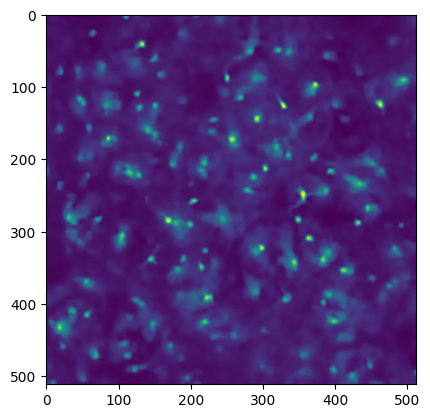

In [3]:
plt.imshow(arr3D[0])

In [10]:
def x(a):
    return x(a - 1) + x(a - 2) + 42 if a > 1 else a
print('%r' % x(10))

3751


In [12]:
def x(a, memo={0: 0, 1: 1}):
    if a in memo:
        return memo[a]
    memo[a] = x(a - 1, memo) + x(a - 2, memo) + 42
    return memo[a]

print('%r' % x(195))

1744559950484785950724677014047127864991062


In [4]:
time = 120
y_1 = 100
y_2 = 120
x_1 = 120
x_2 = 135
subArr3D = arr3D[:time,y_1:y_2, x_1:x_2]
subArr3D.shape

(120, 20, 15)

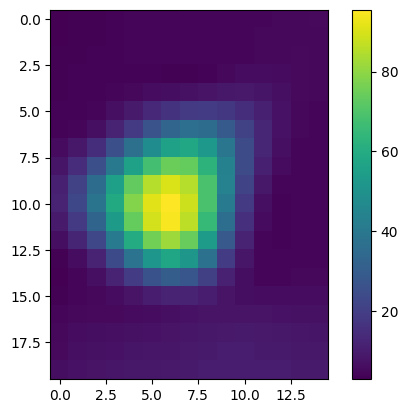

In [5]:
plt.imshow(subArr3D[0])
plt.colorbar()
plt.show()

In [6]:
import numpy as np

def truncated_gaussian_kernel(size, sigma):
    if size % 2 == 0:
        raise ValueError("Размер ядра должен быть нечетным числом")
    mid = size // 2
    x, y = np.mgrid[-mid:mid+1, -mid:mid+1]
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel = kernel[:size, :size]
    kernel /= np.sum(kernel)

    return kernel


In [7]:
subArr3D = np.array(subArr3D)
rowArr, colArr = subArr3D.shape[1], subArr3D.shape[2]
Y = subArr3D.reshape(120,-1).T
time = np.arange(0, Y.shape[1])

In [8]:
rowArr, colArr

(20, 15)

In [9]:
Y.shape

(300, 120)

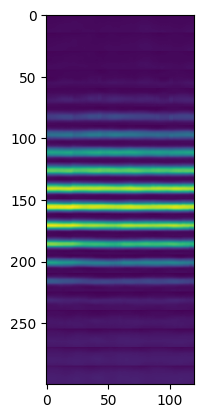

In [10]:
plt.imshow(Y)

In [11]:
from scipy.signal import convolve2d
h = truncated_gaussian_kernel(size=5,sigma=5/4)
Z = convolve2d(Y,h, mode='same', boundary='wrap')

In [12]:
Z.shape

(300, 120)

In [13]:
def calculation_L(Z):
    L = np.zeros(shape=(Z.shape[0],))
    lines = y_2 - y_1
    rows = x_2 - x_1
    for i in range(L.shape[0] - 1):
        if i == 267:
            print(1)
        line, row = i // rows, i % rows
        if (line > 0 and line < lines - 1) and (row > 0 and row < rows - 1):
            neighbors = np.array([(line - 1, row), (line + 1, row), (line, row + 1), (line, row - 1)])
        elif line == 0 and (row > 0 and row < rows - 1):  # Верхний край
            neighbors = np.array([(line + 1, row), (line, row + 1), (line, row - 1)])
        elif line == lines - 1 and (row > 0 and row < rows - 1):  # Нижний край
            neighbors = np.array([(line - 1, row), (line, row + 1), (line, row - 1)])
        elif (line > 0 and line < lines - 1) and row == 0:  # Левый край
            neighbors = np.array([(line - 1, row), (line + 1, row), (line, row + 1)])
        elif (line > 0 and line < lines - 1) and row == rows - 1:  # Правый край
            neighbors = np.array([(line - 1, row), (line + 1, row), (line, row - 1)])
        else:  # Угловые точки
            if line == 0 and row == 0:  # Верхний левый угол
                neighbors = np.array([(line + 1, row), (line, row + 1)])
            elif line == 0 and row == rows - 1:  # Верхний правый угол
                neighbors = np.array([(line + 1, row), (line, row - 1)])
            elif line == lines - 1 and row == 0:  # Нижний левый угол
                neighbors = np.array([(line - 1, row), (line, row + 1)])
            elif line == lines - 1 and row == rows - 1:  # Нижний правый угол
                neighbors = np.array([(line - 1, row), (line, row - 1)])
        tmp = 0
        for neighbor in neighbors:
            tmp += np.corrcoef(Z[i], Z[neighbor[0]*rows + neighbor[1]])[0,1]  
        L[i] = tmp / 4
    return L
    


In [14]:
def calculation_P(Z):
    P = np.zeros(shape=(Z.shape[0]))
    for i,x in enumerate(Z):
        std = np.std(x)
        
        P[i] = np.max(x) / std
    return P

    
    

In [15]:
a = np.random.randint(1, 20, size=(5, 5))
a2 = a.reshape((1,-1))
a

array([[10, 13, 18,  6, 16],
       [ 8, 15, 14, 18, 12],
       [ 8,  1,  4, 17,  2],
       [ 3,  2, 10,  8,  4],
       [11, 17,  2, 16, 12]])

In [16]:
import numpy as np
def omega(x_start, l, rowArr, colArr):
    p = (2*l+1) // 2
    el = x_start  # значение 11
    el_row = el // colArr
    el_col = el % colArr
    row_start = max(int(el // colArr + 1) * colArr - 1 - colArr + 1, el - p)
    row_end = min(el + p + 1, int(el // colArr + 1) * colArr)
    col_start = max(el // colArr - p, 0)
    col_end = min(el // colArr + p + 1, rowArr)

    row = np.arange(row_start, row_end)
    col = np.arange(col_start, col_end)
    result = np.array([])
    for i in col:
        if i < el_row:
            result = np.concatenate((result, row - ((el_row - i) * colArr)))
        elif i == el_row:
            result = np.concatenate((result, row))
        else:
            result = np.concatenate((result, row + ((i - el_row) * colArr)))
    
    return result.astype('int64')


In [17]:
import numpy as np
import cvxpy as cp
def objective(params, Y_Omega_k, c__k, y__BG):
    a1, b__f, b__0 = params[0:300], params[300:600], params[600:]
    a1 = a1.reshape(-1,1)
    b__f = b__f.reshape(-1,1)
    b__0 = b__0.reshape(-1,1)
    c__k = c__k.reshape(1,-1)
    y__BG = y__BG.reshape(1,-1)
    one__arr = np.ones_like(y__BG)
    p = a1@c__k + b__f@y__BG + b__0@one__arr
    frobenius_norm = np.linalg.norm(Y_Omega_k - p, 'fro')
    #print(frobenius_norm)
    #print('a1', a1[:5])
    return frobenius_norm



In [18]:
def constraint_func(x):
    constraints = []
    for var in x:
        constraints.append({'type': 'ineq', 'fun': lambda var: var})
    return constraints

In [19]:
def initialize_model(Y):
    h = truncated_gaussian_kernel(size=5,sigma=5/4)
    Z = convolve2d(Y,h, mode='same', boundary='wrap')
    L = calculation_L(Z)
    P = calculation_P(Z)
    k = 0
    L_min = 0.4
    P_min = 10
    limit = 300
    d = 300
    a = np.random.uniform(size=(L.shape[0],))
    b_f = np.random.uniform(size=(L.shape[0],))
    b_0 = np.random.uniform(size=(L.shape[0],))
    A = []
    C = []
    while True:
        if np.all(L <= L_min) or np.all(P <= P_min):
            break
        else:
            print('k', k)
            a[k] = 0
            x_star = np.argmax(np.multiply(L,P))
            Omega_k = omega(x_star, l=5,rowArr=rowArr,colArr=colArr)
            r = np.zeros(len(Omega_k))
            for i, x in enumerate(Omega_k):
                r[i] = np.corrcoef(Z[x,:], Z[x_star,:])[0,1]
            y_BG = np.mean(Y[Omega_k[r <=0.3], :], axis=0)
            c_k = np.mean(Z[Omega_k[r >=0.7], :], axis=0)
            bounds = []
            for i in range(3):  # 3 переменные a, b_f, b_0
                bounds.append([(0, None) for _ in range(300)])


            #print(a)
            x0 = np.concatenate((a, b_f, b_0))
            res = minimize(objective, x0, args=(Y,c_k,y_BG), constraints=constraint_func([a,b_f,b_0]), tol = 1e-1)
            
            new_a, new_b_f, new_b_0 = res.x[:limit].copy(), res.x[limit: 2*limit].copy(), res.x[3*limit:].copy()
            #print('a', a)
            # new_a = a.value
            # new_b_f = b_f.value
            # new_b_0 = b_0.value
            Y = Y - new_a.reshape(-1,1) @ c_k.reshape(1,-1)
            Z = convolve2d(Y,h, mode='same', boundary='wrap')
            L = calculation_L(Z)
            P = calculation_P(Z)
            print(Y.shape)
            A.append(a)
            C.append(c_k)
            k += 1
    return A, C







In [20]:
0.6931/(0.001918*10**(-6))

361366006.2565173

In [21]:
# import numpy as np
# from scipy.optimize import minimize

# def objective_function(W, X, d):
#     W = W.reshape((d, d)) 
#     #return (X - np.dot(W, X)).shape # shape = (300,120)
#     return np.linalg.norm(X - np.dot(W, X), 'fro')
# def constraint_function(W_flat, l, d):
#     W = W_flat.reshape((d, d))
#     mask = (W < l) | (W > l + 1)
#     W[mask] = 0
#     return W.flatten() - W_flat


# # def estimate_background(Y, A_hat, C_hat, l, d):
# #     A_hat = A_hat.T
# #     T = Y.shape[1] # T == 120
# #     b0 = (Y - A_hat @ C_hat) @ np.ones((T, 1))
# #     X = Y - np.dot(A_hat, C_hat) - np.dot(b0, np.ones((1, T))) # X.shape == (300,120)
# #     W_init = np.zeros((300,300)) # d == 300
# #     cons = ({'type': 'eq', 'fun': lambda w: constraint_function(w, l, d)})
# #     result = minimize(objective_function, x0=W_init, args=(X, d), constraints=cons)

# #     optimal_W = result.x.reshape((d, d))

# #     return optimal_W


In [22]:
A, C = initialize_model(Y)


1
k 0
1
(300, 120)
k 1
1
(300, 120)


In [23]:
A = np.array(A)
C = np.array(C)
AC = A.T @ C

In [24]:
A.shape

(2, 300)

In [25]:
C.shape

(2, 120)

In [26]:
import numpy as np
import cvxpy as cp

def estimate_background(Y, A_hat, C_hat, l, d):
    A_hat = A_hat.T
    T = Y.shape[1]
    b0 = (Y - A_hat @ C_hat) @ np.ones((T, 1))
    X = Y - np.dot(A_hat, C_hat) - np.dot(b0, np.ones((1, T)))
    W = cp.Variable((d, d))
    objective = cp.Minimize(cp.norm(X - W @ X, 'fro'))
    constraints = [l <= W, W <= l+1]
    problem = cp.Problem(objective, constraints)
    problem.solve()
    optimal_W = W.value
    return optimal_W


In [ ]:
arr

In [27]:
A_hat = A.T
T = Y.shape[1]
W = estimate_background(Y, A, C, 3, Y.shape[0])

c:\Users\rusan\AppData\Local\Programs\Python\Python311\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [28]:
b0 = (Y - A_hat @ C) @ np.ones((T, 1))
X = Y - np.dot(A_hat, C) - np.dot(b0, np.ones((1, T)))

In [29]:
B_mod =  W@X + b0@np.ones((1, T))

In [30]:
B_mod.shape

(300, 120)

In [31]:
#P-S`
Y_mod = Y - B_mod - Y@np.ones((T,1))*(1/T)
C_mod = C - C@np.ones((T,1))*(1/T)
A = cp.Variable((A.shape[1], A.shape[0]))
objective = cp.Minimize(cp.norm(Y_mod - A @ C_mod, 'fro'))
constraints = [A >= 0]
problem = cp.Problem(objective, constraints)
problem.solve()
optimal_A = A.value

In [32]:
#P-S`

